In [1]:
# Import VADER for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of the analyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
import pandas as pd

clean_file_path = r"C:\Users\comat\GitProjects\customer-churn-ai\data\cleaned_telco_churn.csv"

try:
    df_clean = pd.read_csv(clean_file_path)
    print("Data Loaded Successfully! Sensational!")
except FileNotFoundError:
    print(f"Error: File not found at {clean_file_path}. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

Data Loaded Successfully! Sensational!


In [ ]:
# Define a function to get the compound score (and other scores if you want)
def get_vader_sentiment(text):
    # VADER can handle NaNs or non-string types gracefully, but it's good practice
    # to ensure we're passing strings or handle potential errors if other types exist.
    if isinstance(text, str):
        return analyzer.polarity_scores(text)
    return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Default for non-strings/NaN

# Apply the function to your CustomerReview column
# This will create a new Series where each item is a dictionary of scores
sentiment_scores_series = df_clean['CustomerReview'].apply(get_vader_sentiment)

# Convert the Series of dictionaries into separate columns in your DataFrame
df_sentiment_scores = pd.DataFrame(sentiment_scores_series.tolist())

# Rename columns for clarity (optional, but good practice)
df_sentiment_scores.rename(columns={
    'neg': 'VADER_Negative',
    'neu': 'VADER_Neutral',
    'pos': 'VADER_Positive',
    'compound': 'VADER_Compound'
}, inplace=True)

# Join these new sentiment score columns with original DF, Assign to a new DF
df_sentiment = pd.concat([df_clean, df_sentiment_scores], axis=1)

print("VADER sentiment scores added to the DataFrame.")

VADER sentiment scores added to the DataFrame.


In [4]:
df_sentiment[['Churn','CustomerReview', 'VADER_Negative', 'VADER_Neutral', 'VADER_Positive', 'VADER_Compound']].head()

,Churn,CustomerReview,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound
0,No,Really happy with my plan... no unexpected fee...,0.128,0.640,0.232,0.4201
1,No,Really happy with my plan... phone support was...,0.000,0.457,0.543,0.8588
2,Yes,"Unfortunately, my service was... frustrated by...",0.453,0.547,0.000,-0.7003
3,No,Consistently good signal... data plan is a gre...,0.000,0.539,0.461,0.8555
4,Yes,Not satisfied with the billing... billing erro...,0.372,0.628,0.000,-0.5764


In [5]:
import numpy as np

In [6]:
# Define the conditions based on the thresholds
conditions = [
    df_sentiment['VADER_Compound'] >= 0.05,   # Positive
    df_sentiment['VADER_Compound'] <= -0.05,  # Negative
    (df_sentiment['VADER_Compound'] > -0.05) & (df_sentiment['VADER_Compound'] < 0.05) # Explicitly neutral
]

# Define the corresponding sentiment labels
choices = ['Positive', 'Negative', 'Neutral']

# Create the 'Sentiment_Label' column
"""
conditions: list of our logical conditions
choices: list contains of labels we want to assign for each condition, in the same order
NumPy function applies conditions and choices. If none of the conditions are met for a row
(which shouldn't happen with these specific conditions if VADER_Compound is a valid number),
it would assign the default value.
"""
df_sentiment["Sentiment_Label"] = np.select(conditions, choices, default='Neutral')
# The default might catch any edge cases or NaNs if VADER_Compound was NaN, though our previous get_vader_sentiment handled NaNs in text.

print("\nSentiment_Labels column created based on VADER_Compound scores and added to the DataFrame.")


Sentiment_Labels column created based on VADER_Compound scores and added to the DataFrame.


---
##### Review the Distribution of Sentiment Labels

In [7]:
print("\nDistribution of Sentiment Labels:")
print(df_sentiment["Sentiment_Label"].value_counts())


Distribution of Sentiment Labels:
Sentiment_Label
Positive    5219
Negative    1548
Neutral      276
Name: count, dtype: int64


In [8]:
print("\nDistribution of Sentiment as Percentages:")
print(df_sentiment["Sentiment_Label"].value_counts(normalize=True).map(lambda x: float(f'{x:.4f}')))


Distribution of Sentiment as Percentages:
Sentiment_Label
Positive    0.7410
Negative    0.2198
Neutral     0.0392
Name: proportion, dtype: float64


In [9]:
# Display the first few rows with the new Sentiment_Label column
print("\nDataFrame with Sentiment Labels (first 5 rows):")
df_sentiment[['CustomerReview', 'VADER_Compound', 'Sentiment_Label','Churn']].head()


DataFrame with Sentiment Labels (first 5 rows):


,CustomerReview,VADER_Compound,Sentiment_Label,Churn
0,Really happy with my plan... no unexpected fee...,0.4201,Positive,No
1,Really happy with my plan... phone support was...,0.8588,Positive,No
2,"Unfortunately, my service was... frustrated by...",-0.7003,Negative,Yes
3,Consistently good signal... data plan is a gre...,0.8555,Positive,No
4,Not satisfied with the billing... billing erro...,-0.5764,Negative,Yes


##### Results:
* `Positive`: The Majority 74%. Seems common in many review datasets as customers who have a decent or good experience might be prompted to leave a review, or the service generally satisfies most.
* `Negative`: Seems small at ~22%. This could mean the service is generally very good for customers, OR it could mean I may need to revise sentiment thresholds.
* `Neutral`: Wildly small at ~4%  
---
* Remember the Reviews were populated by AI, so they are not representative of the actual product or data.
* This is for Learning Purposes
---

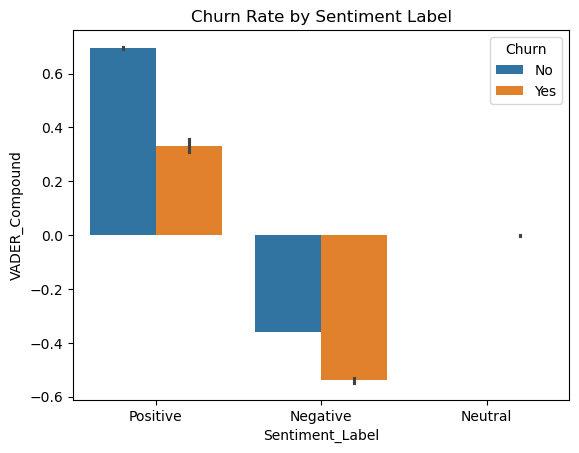

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Compound', hue='Churn')
ax.set_title('Churn Rate by Sentiment Label')
plt.show()

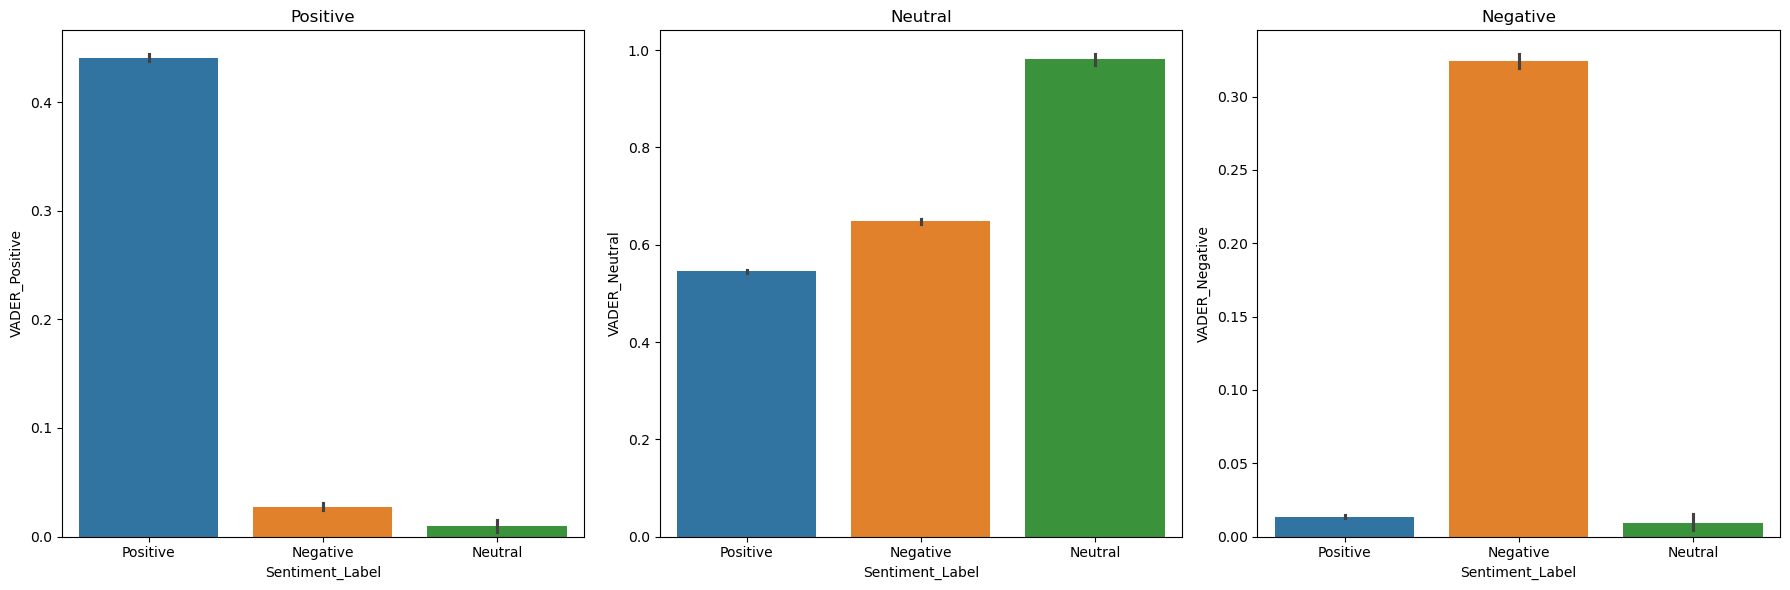

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Positive', hue='Sentiment_Label', ax=ax[0])
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Neutral', hue='Sentiment_Label',ax=ax[1])
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Negative', hue='Sentiment_Label',ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

---
### Hugging Face Transformer - Sentiment Analysis

In [12]:
from transformers import pipeline
# Initialize the sentiment analysis pipeline with our chosen model
# This will download the model if you haven't used it before (can take a few minutes and some disk space)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

print("Hugging Face sentiment analysis pipeline initialized successfully!")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Hugging Face sentiment analysis pipeline initialized successfully!


In [13]:
print("Preparing review texts...")
# Convert the CustomerReview column to a list, replacing NaN with empty strings
# as the pipeline expects string inputs.
review_texts = df_sentiment['CustomerReview'].fillna('').tolist()

print(f"Starting sentiment prediction for {len(review_texts)} reviews... (This may take a few minutes)")
# Get predictions for all texts
# This might take some time depending on the number of reviews and your hardware
hf_predictions = sentiment_pipeline(review_texts)

print(f"\nProcessed {len(hf_predictions)} reviews with Hugging Face model.")


Preparing review texts...
Starting sentiment prediction for 7043 reviews... (This may take a few minutes)

Processed 7043 reviews with Hugging Face model.


In [14]:
# You can inspect the first few predictions to see their structure if you like:
print("\nSample Hugging Face predictions (first 3):")
for i in range(min(3, len(hf_predictions))):
    print(f"Review snippet: {review_texts[i][:100]}...")
    print(f"Prediction: {hf_predictions[i]}")


Sample Hugging Face predictions (first 3):
Review snippet: Really happy with my plan... no unexpected fees. Made the right choice here....
Prediction: {'label': 'positive', 'score': 0.9732906222343445}
Review snippet: Really happy with my plan... phone support was helpful and polite....
Prediction: {'label': 'positive', 'score': 0.9825600981712341}
Review snippet: Unfortunately, my service was... frustrated by the slow data....
Prediction: {'label': 'negative', 'score': 0.9061986207962036}


In [15]:
print("\nProcessing predictions and adding to DataFrame...")
# Extract labels and scores
hf_labels_raw = [pred['label'] for pred in hf_predictions]
hf_scores = [pred['score'] for pred in hf_predictions]

# Define the mapping from the model's output labels to our desired text labels
# For cardiffnlp/twitter-roberta-base-sentiment-latest:
# 0 -> Negative (LABEL_0)
# 1 -> Neutral  (LABEL_1)
# 2 -> Positive (LABEL_2)
label_mapping = {
    "negative": "Negative",
    "neutral": "Neutral",
    "positive": "Positive"
}

# Map the raw labels to text labels
hf_sentiment_labels = [label_mapping.get(label, "Unknown") for label in hf_labels_raw] # Added "Unknown" for safety

# Add as new columns to your DataFrame
df_sentiment['HF_Sentiment_Label'] = hf_sentiment_labels
df_sentiment['HF_Sentiment_Score'] = hf_scores

print("Hugging Face sentiment labels and scores added to DataFrame.")


Processing predictions and adding to DataFrame...
Hugging Face sentiment labels and scores added to DataFrame.


In [ ]:
print("\nDataFrame with Hugging Face Sentiment (first 5 rows):")
print(df_sentiment[['CustomerReview', 'HF_Sentiment_Label', 'HF_Sentiment_Score', 'VADER_Compound', 'Sentiment_Label']].head()) # Comparing with VADER

# Display the counts of each new sentiment label
print("\nDistribution of Hugging Face Sentiment Labels:")
print(df_sentiment['HF_Sentiment_Label'].value_counts())

# Display the percentage distribution (capped at 3 decimals)
print("\nDistribution of Hugging Face Sentiment as Percentages:")
hf_percentages = df_sentiment["HF_Sentiment_Label"].value_counts(normalize=True) * 100
print(hf_percentages.round(3))  # Using your preferred 4-decimal formatting: print(hf_percentages.map(lambda x: float(f'{x:.4f}')))
# Or for 3 decimal places: # print(hf_percentages.round(3))


DataFrame with Hugging Face Sentiment (first 5 rows):
                                      CustomerReview HF_Sentiment_Label  \
0  Really happy with my plan... no unexpected fee...           Positive   
1  Really happy with my plan... phone support was...           Positive   
2  Unfortunately, my service was... frustrated by...           Negative   
3  Consistently good signal... data plan is a gre...           Positive   
4  Not satisfied with the billing... billing erro...           Negative   

   HF_Sentiment_Score  VADER_Compound Sentiment_Label  
0            0.973291          0.4201        Positive  
1            0.982560          0.8588        Positive  
2            0.906199         -0.7003        Negative  
3            0.960772          0.8555        Positive  
4            0.930403         -0.5764        Negative  

Distribution of Hugging Face Sentiment Labels:
HF_Sentiment_Label
Positive    5177
Negative    1818
Neutral       48
Name: count, dtype: int64

Distribution 

##### COMPARISON:
**Key Differences:**
* Hugging Face classified far fewer reviews as "Neutral" (only 48 compared to VADER's 276).
* Hugging Face model classified more reviews as "Negative" (1818 compared to VADER's 1548).
* Number of "Positive" reviews is fairly similar, with VADER being slightly higher.  

**Potential Reasons**
* The "Disappearing Neutrals":
    * Biggest difference is the reduction in neutral reviews with the Hugging Face model. Suggests many of the reviews VADER considered neutral had enough subtle cues (positive or negative) for the more context-aware RoBERTa model to assign them a more definitive sentiment classification.
    * The cardiffnlp model is trained to output one of three labels (Negative, Neutral, Positive). Its architecture is designed to make a choice among these. VADER's compound score is continuous, and we chose thresholds to define neutral; a different threshold choice for VADER would also change its neutral count.

* Increase in "Negative" for Hugging Face Model:
    * It seems that a good portion of what VADER saw as "Neutral" (and perhaps a few from VADER's "Positive") are now being classified as "Negative" by the RoBERTa model.
    * This could be because RoBERTa, with its deeper understanding of language context and semantics (learned from ~124M tweets), is better at picking up subtle dissatisfaction, sarcasm, or implied negativity that VADER's lexicon-based approach might miss or downplay.

**Impact / Relevance on Churn Analysis:**
* A model that identifies more "Negative" reviews (if those negative sentiments are genuine reflections of dissatisfaction) might provide a stronger signal for your churn prediction model. If customers who the RoBERTa model flags as "Negative" (but VADER might have called "Neutral") are indeed more likely to churn, then this more sensitive model could be more valuable.

**Insights:**
* Could probably tune VADER to get similar results to the RoBERTa model, but that's too much work. Go with RoBERTa.

**Additional Practice:**
* Look at some examples:
    * Reviews that VADER called "Neutral" but the Hugging Face model called "Negative."  
    
    * Reviews that VADER called "Neutral" but the Hugging Face model called "Positive." This can help you understand why the models differ and which one seems more aligned with human interpretation for your specific data.
